<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/BTC_EquityBinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Best Parameters: (0.4, 0.15, 1.0, 1.5, 1.0)
Best Final Balance: -53902.241692039104
Final Balance: -53902.241692039104
Maximum Drawdown: 63902.241692039104
Worst Trade Loss: -678.0485039062507


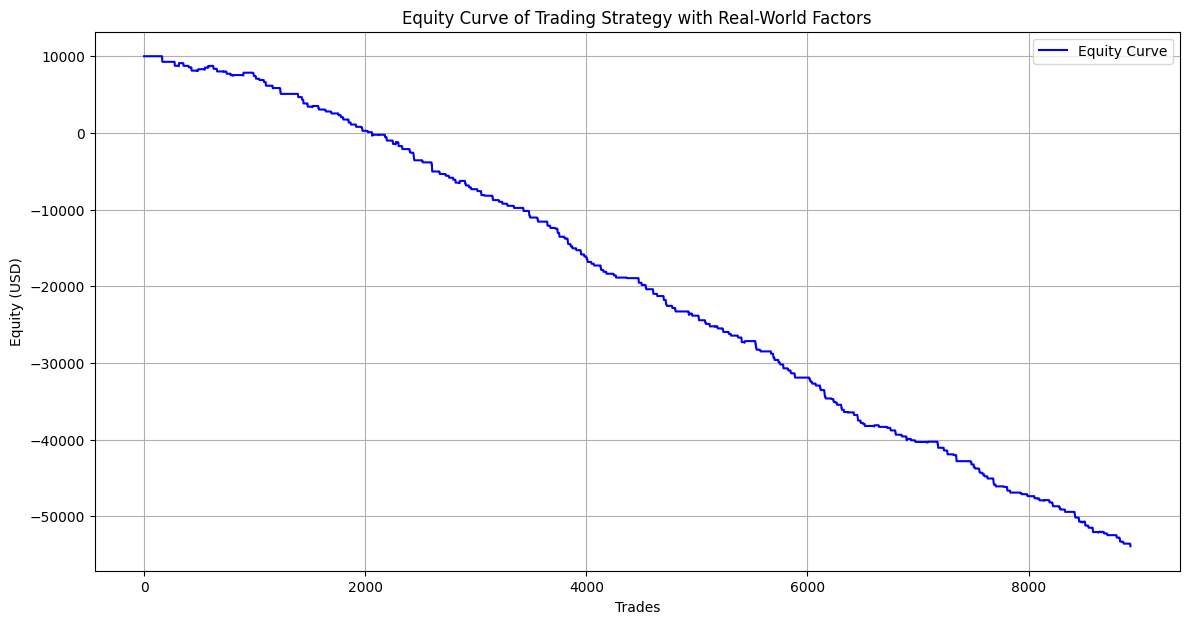

In [ ]:
# Install necessary libraries (run these commands only once)
!pip install yfinance pandas_ta matplotlib

import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Fetch BTCUSDT data from Yahoo Finance with a 1-month period (for 5-minute data)
def fetch_btcusdt_data():
    btc_data = yf.download('BTC-USD', interval='5m', period='1mo')  # '5m' interval for the last 1 month
    btc_data = btc_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    return btc_data

# Fetch BTCUSDT data
btc_futures_data = fetch_btcusdt_data()

# Ensure data is available
if btc_futures_data.empty:
    raise ValueError("No data available from Yahoo Finance for the requested period and interval.")

# Adding ATR, RSI, MACD using pandas_ta
btc_futures_data['ATR'] = ta.atr(btc_futures_data['high'], btc_futures_data['low'], btc_futures_data['close'], length=14)
btc_futures_data['RSI'] = ta.rsi(btc_futures_data['close'], length=14)

macd = ta.macd(btc_futures_data['close'], fast=12, slow=26, signal=9)
if macd is not None:
    btc_futures_data['MACD'] = macd['MACD_12_26_9']
else:
    raise ValueError("MACD calculation failed, check the input data.")

# Correctly adding Bollinger Bands
bb_bands = ta.bbands(btc_futures_data['close'], length=20, std=2)
btc_futures_data['BB_upper'] = bb_bands['BBU_20_2.0']
btc_futures_data['BB_middle'] = bb_bands['BBM_20_2.0']
btc_futures_data['BB_lower'] = bb_bands['BBL_20_2.0']

# Adding Stochastic Oscillator
stoch = ta.stoch(btc_futures_data['high'], btc_futures_data['low'], btc_futures_data['close'], k=14, d=3)
btc_futures_data['StochK'] = stoch['STOCHk_14_3_3']
btc_futures_data['StochD'] = stoch['STOCHd_14_3_3']

# Function to calculate the dynamic MRSI indicator
def calculate_dynamic_mrsi(data, theta):
    mu = data['close'].rolling(window=50).mean()  # Using a longer rolling window for smoothing
    sigma = data['ATR']  # Use ATR as dynamic volatility
    deviation = mu - data['close']
    mrsi = theta * deviation / sigma
    return mrsi

# Example parameter values for MRSI calculation
theta = 0.7  # Adjusted Speed of mean reversion for more sensitivity

# Calculate MRSI and add to the DataFrame
btc_futures_data['MRSI'] = calculate_dynamic_mrsi(btc_futures_data, theta)

# Apply smoothing to MRSI
btc_futures_data['MRSI_Smoothed'] = btc_futures_data['MRSI'].ewm(span=10, adjust=False).mean()  # Adjusted EMA span

# Backtesting the MRSI strategy with real-world factors
def backtest_mrsi_strategy(data, entry_threshold=0.2, exit_threshold=0.15, stop_loss_factor=0.75, take_profit_factor=2.0, trail_stop_factor=0.5, transaction_cost=0.001, slippage=0.001):
    initial_balance = 10000  # Starting balance in USDT
    balance = initial_balance
    position = 0  # 0: no position, 1: long, -1: short
    trade_log = []
    equity_curve = [initial_balance]  # Track equity over time
    entry_price = 0
    trail_stop_price = None

    peak_balance = initial_balance
    max_drawdown = 0
    worst_trade_loss = 0

    for i in range(1, len(data)):
        mrsi = data['MRSI_Smoothed'].iloc[i]
        rsi = data['RSI'].iloc[i]
        macd = data['MACD'].iloc[i]
        stoch_k = data['StochK'].iloc[i]
        stoch_d = data['StochD'].iloc[i]
        price = data['close'].iloc[i]
        atr = data['ATR'].iloc[i]

        # Adjust price for slippage
        slippage_adjustment = price * slippage

        # Dynamic stop-loss, take-profit, and trailing stop based on ATR
        stop_loss = stop_loss_factor * atr
        take_profit = take_profit_factor * atr
        trail_stop = trail_stop_factor * atr

        if position == 0:
            if mrsi < -entry_threshold and rsi < 50 and macd > 0 and stoch_k < 20:
                position = 1
                entry_price = price + slippage_adjustment  # Buy with slippage
                trail_stop_price = price - trail_stop
                trade_log.append(('BUY', entry_price, data.index[i]))
                balance -= entry_price * transaction_cost  # Subtract transaction cost
            elif mrsi > entry_threshold and rsi > 50 and macd < 0 and stoch_k > 80:
                position = -1
                entry_price = price - slippage_adjustment  # Sell with slippage
                trail_stop_price = price + trail_stop
                trade_log.append(('SELL', entry_price, data.index[i]))
                balance -= entry_price * transaction_cost  # Subtract transaction cost

        elif position == 1:
            if price - trail_stop > trail_stop_price:
                trail_stop_price = price - trail_stop

            if price <= entry_price - stop_loss or price >= entry_price + take_profit or price <= trail_stop_price or mrsi > exit_threshold:
                trade_profit = price - entry_price - price * transaction_cost - slippage_adjustment
                balance += trade_profit
                position = 0
                trail_stop_price = None
                trade_log.append(('SELL', price, data.index[i], 'WIN' if trade_profit > 0 else 'LOSS'))
                if trade_profit < worst_trade_loss:
                    worst_trade_loss = trade_profit

        elif position == -1:
            if price + trail_stop < trail_stop_price:
                trail_stop_price = price + trail_stop

            if price >= entry_price + stop_loss or price <= entry_price - take_profit or price >= trail_stop_price or mrsi < -exit_threshold:
                trade_profit = entry_price - price - price * transaction_cost - slippage_adjustment
                balance += trade_profit
                position = 0
                trail_stop_price = None
                trade_log.append(('BUY', price, data.index[i], 'WIN' if trade_profit > 0 else 'LOSS'))
                if trade_profit < worst_trade_loss:
                    worst_trade_loss = trade_profit

        if balance > peak_balance:
            peak_balance = balance
        drawdown = peak_balance - balance
        if drawdown > max_drawdown:
            max_drawdown = drawdown

        equity_curve.append(balance)

    return balance, trade_log, max_drawdown, worst_trade_loss, equity_curve

# Add a grid search for parameter optimization
def optimize_parameters(data):
    best_params = None
    best_performance = float('-inf')

    entry_thresholds = [0.1, 0.2, 0.3, 0.4]
    exit_thresholds = [0.05, 0.1, 0.15, 0.2]
    stop_loss_factors = [0.5, 0.75, 1.0]
    take_profit_factors = [1.5, 2.0, 2.5]
    trail_stop_factors = [0.5, 0.75, 1.0]

    for entry_th, exit_th, sl, tp, ts in itertools.product(entry_thresholds, exit_thresholds, stop_loss_factors, take_profit_factors, trail_stop_factors):
        final_balance, _, _, _, _ = backtest_mrsi_strategy(data, entry_threshold=entry_th, exit_threshold=exit_th, stop_loss_factor=sl, take_profit_factor=tp, trail_stop_factor=ts)

        if final_balance > best_performance:
            best_performance = final_balance
            best_params = (entry_th, exit_th, sl, tp, ts)

    return best_params, best_performance

# Run the optimization
best_params, best_performance = optimize_parameters(btc_futures_data)
print(f"Best Parameters: {best_params}")
print(f"Best Final Balance: {best_performance}")

# Re-run the backtest with the best parameters
final_balance, trade_log, max_drawdown, worst_trade_loss, equity_curve = backtest_mrsi_strategy(btc_futures_data,
    entry_threshold=best_params[0],
    exit_threshold=best_params[1],
    stop_loss_factor=best_params[2],
    take_profit_factor=best_params[3],
    trail_stop_factor=best_params[4]
)

print(f"Final Balance: {final_balance}")
print(f"Maximum Drawdown: {max_drawdown}")
print(f"Worst Trade Loss: {worst_trade_loss}")

# Plot the equity curve
plt.figure(figsize=(14, 7))
plt.plot(equity_curve, label='Equity Curve', color='blue')
plt.title('Equity Curve of Trading Strategy with Real-World Factors')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
plt.legend()
plt.grid(True)
plt.show()
